# Search engine - Introduction
This is the fifth and last part of my [dezeenAI](https://github.com/adamsiemaszkiewicz/dezeenAI) project meant to build an object and colour detection search engine based on the [Dezeen.com](http://dezeen.com/)'s Interior category.

This notebook presents the proof-of-concept search engine.

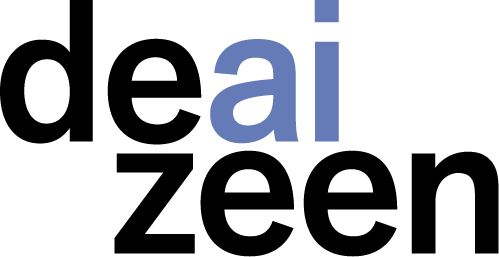

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/dezeenAI': File exists
/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Install missing libraries

In [3]:
!pip install streamlit

## Libraries & functions
- `requests` - http handling
- `BeautifulSoup` - html parsing & web-scraping
- `urllib.request` - url-opening
- `tqdm` - loop progress bar
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `sys` - system-specific parameters & functions
- `HTML` - clickable links


In [4]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import streamlit as st

# Import DataFrames

## Articles

In [5]:
articles_df = pd.read_csv('files/df_articles.csv', index_col=0)
articles_df

,id,title,url
0,1596617,Freadman White completes Napier Street apartme...,https://www.dezeen.com/2020/12/14/napier-stree...
1,1596239,Meditation chambers by Office Of Things wash w...,https://www.dezeen.com/2020/12/13/meditation-r...
2,1594952,Library of law books wraps staircase in Mexico...,https://www.dezeen.com/2020/12/12/corporate-c-...
3,1596233,"""Grey alone would be too depressing for 2021's...",https://www.dezeen.com/2020/12/11/colour-of-th...
4,1595772,Seaside hotel by K-studio declared Ultimate Wi...,https://www.dezeen.com/2020/12/11/ultimate-win...
...,...,...,...
4985,70,Marcel Wanders launches Crochet Chair,https://www.dezeen.com/2006/12/10/marcel-wande...
4986,67,WOKmedia show at Design Miami,https://www.dezeen.com/2006/12/10/wokmedia-sho...
4987,54,Zaha Hadid furniture exhibited in New York,https://www.dezeen.com/2006/12/07/zaha-hadid-f...
4988,48,Thomas Heatherwick beach cafe takes shape,https://www.dezeen.com/2006/12/04/thomas-heath...


## Colors

In [6]:
colors_df = pd.read_pickle('files/df_images-colours.pkl')
colors_df

,id,url,path,colours,distribution
0,15,http://static.dezeen.com/uploads/2006/11/k.jpg,/mydrive/data/dezeen/15/k.jpg,"[[146.0, 122.92307692307692, 88.3076923076923]...","[0.05078125, 0.1640625, 0.05859375, 0.1875, 0...."
1,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg,"[[98.95348837209302, 82.30232558139535, 51.534...","[0.16796875, 0.05078125, 0.03515625, 0.0742187..."
2,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg,"[[71.50877192982456, 57.64912280701755, 35.912...","[0.22265625, 0.046875, 0.15234375, 0.13671875,..."
3,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg,"[[2.411764705882348, 8.54117647058824, 19.2000...","[0.33203125, 0.09375, 0.03515625, 0.06640625, ..."
4,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,"[[101.34146341463415, 80.46341463414635, 48.68...","[0.16015625, 0.06640625, 0.0625, 0.046875, 0.1..."
...,...,...,...,...,...
47224,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,"[[192.26666666666665, 177.86666666666667, 164....","[0.05859375, 0.234375, 0.078125, 0.0625, 0.074..."
47225,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,"[[147.8181818181818, 136.3181818181818, 131.27...","[0.0859375, 0.11328125, 0.15234375, 0.04296875..."
47226,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,"[[125.11111111111111, 97.38888888888889, 70.05...","[0.140625, 0.09765625, 0.05859375, 0.12890625,..."
47227,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,"[[83.22727272727272, 80.04545454545455, 21.590...","[0.0859375, 0.05859375, 0.203125, 0.1015625, 0..."


## Objects

In [7]:
objects_df = pd.read_csv('files/images_objectsbasic.csv', index_col=0)
objects_df

,id,url,path,person,person_conf,bicycle,bicycle_conf,car,car_conf,bench,bench_conf,cat,cat_conf,dog,dog_conf,sports ball,sports ball_conf,skateboard,skateboard_conf,bottle,bottle_conf,wine glass,wine glass_conf,cup,cup_conf,fork,fork_conf,knife,knife_conf,spoon,spoon_conf,bowl,bowl_conf,chair,chair_conf,sofa,sofa_conf,pottedplant,pottedplant_conf,bed,bed_conf,diningtable,diningtable_conf,toilet,toilet_conf,tvmonitor,tvmonitor_conf,laptop,laptop_conf,keyboard,keyboard_conf,microwave,microwave_conf,oven,oven_conf,sink,sink_conf,refrigerator,refrigerator_conf,book,book_conf,clock,clock_conf,vase,vase_conf
0,15,http://static.dezeen.com/uploads/2006/11/k.jpg,/mydrive/data/dezeen/15/k.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
1,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.350172,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
2,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
3,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
4,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,2,0.259486,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,1,0.32862,0,0.0,0,0.0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47224,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0.491402,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,3,0.389218,1,0.363451,0,0.000000,1,0.579165,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
47225,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,2,0.836554,0,0.000000,7,0.619697,0,0.000000,2,0.251881,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,1,0.661205
47226,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,4,0.293785,0,0.0,0,0.0,0,0.0,2,0.497962,4,0.567412,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,1,0.886706,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
47227,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,10,0.745079,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,1,0.267047,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000


# Object search

In [8]:
def objectGrid(class_name, sort='quantity', output=(4,4)):
  
  '''
  Takes the class name to find together with search parameters and outputs
  search results as a images grid.

  Parameters:
  class_name (str): Name of the class to find
  sort (str): sorting method
    `quantity` sort according to quantity of objects found (default)
    `confidence` sort according to find confidence
  output (tuple of integers): size of the image grid (rows, columns)

  Returns:
  An image grid with object search results
  '''

  # establish total number of elements to display
  number_of_elements = output[0] * output[1]

  # sort according to specified method
  if sort == 'quantity':
    df_search = objects_df.sort_values([class_name, class_name+'_conf'], ascending=False)
  elif sort == 'confidence':
    df_search = objects_df.sort_values([class_name+'_conf'], ascending=False)

  # fetch lists of image paths and article ids for search results
  paths = df_search['path'][:number_of_elements]
  ids = df_search['id'][:number_of_elements]

  # set up subplot according to output size
  fig, axs = plt.subplots(
      nrows=output[0],
      ncols=output[1],
      figsize=(output[1]*5, output[0]*5)
      )
  # set the main title
  fig.suptitle(f'Search results for "{class_name}"')

  # iterate through subplots to update their contents
  for n, ax in enumerate(axs.flat):

    # swtich of axis
    ax.axis('off')

    # retrieve article id and title
    id = ids.iloc[n]
    title = articles_df[articles_df['id'] == id]['title'].to_string(index=False)
    url = articles_df[articles_df['id'] == id]['url'].to_string(index=False)

    # set the title
    ax.set_title(
        title[:40]+
        '...\n'+
        url[:40]+'...'
        )

    # read the file
    image = cv2.imread(paths.iloc[n])

    # resize the image
    height, width = image.shape[:2]
    resized_image = cv2.resize(
      image,
      (2*width, 2*height),
      interpolation = cv2.INTER_CUBIC
      )
    
    # display image
    ax.imshow(
        cv2.cvtColor(
            resized_image,
            cv2.COLOR_BGR2RGB
            )
        )

In [10]:
objectGrid('sofa', sort='confidence', output=(10,4))

Output hidden; open in https://colab.research.google.com to view.

# Color search
Let's build a color search engine. To do it we will need two important functions:
- `rgb2hsv()` converts RGB color values to HSV
- `closestColor()` finds a color within a given list which distance is the closest to the refernece color

In [12]:
def rgb2hsv(color):

  '''
  Takes a color in RGB format and converts it HSV format.

  Parameters:
  color (list): Color in the RGB format as a list of R, G, B values

  Returns:
  A converted color in HSV format.
  '''
  
  r, g, b = color[0]/255.0, color[1]/255.0, color[2]/255.0
  mx = max(r, g, b)
  mn = min(r, g, b)
  df = mx-mn
  if mx == mn:
    h = 0
  elif mx == r:
    h = (60 * ((g-b)/df) + 360) % 360
  elif mx == g:
    h = (60 * ((b-r)/df) + 120) % 360
  elif mx == b:
    h = (60 * ((r-g)/df) + 240) % 360
  if mx == 0:
    s = 0
  else:
    s = (df/mx)*100
  
  v = mx*100
  color = [h, s, v]
  return color

In [13]:
def closestColor(reference_color, list_of_colors):

  '''
  Takes a reference color and finds a closest color withing a given color list.

  Parameters:
  reference_color (list): Reference color in a RGB format
  list_of_colors (list): List of colors in a RGB format

  Returns:
  A color within a list the closest to the reference color and distance between them.
  '''
  
  # initiate the distance to be a really big number and closest_color as empty
  shortest_distance, closest_color = sys.maxsize, None

  # check if the color container is not NaN
  if isinstance(list_of_colors, np.ndarray):
    
    # iterate through all the colors
    for color in list_of_colors:      
      # calculate the Euclidean distance to the reference color (sum of squared distances of each value)
      current_distance = pow(rgb2hsv(color)[0] - rgb2hsv(reference_color)[0], 2) + \
                         pow(rgb2hsv(color)[1] - rgb2hsv(reference_color)[1], 2) + \
                         pow(rgb2hsv(color)[2] - rgb2hsv(reference_color)[2], 2)


      # update the distance along with the corresponding color
      if current_distance < shortest_distance:
        shortest_distance = current_distance
        closest_color = color    

  return closest_color, shortest_distance

### Proof of concept
Let's ilustrate how the search engine works based on a random example.


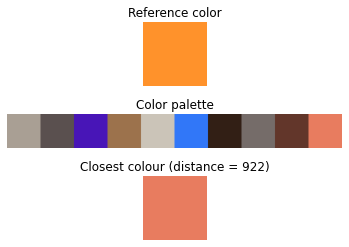

In [45]:
def plotClosestColor(reference_color=None, list_of_colors=None):

  '''
  Plots a visual representation of closestColor() function

  Parameters:
  reference_color (list): Reference color in a RGB format
  list_of_colors (list): List of colors in a RGB format

  Returns:
  A color within a list the closest to the reference color and distance between them.
  '''

  # pick random if reference color not specified
  if reference_color == None:    
    reference_color = [
                       np.random.randint(0, 255),
                       np.random.randint(0, 255),
                       np.random.randint(0, 255) 
                       ]

  # pick random if no list of colors specified
  if list_of_colors == None:    
    random_row = np.random.randint(0, colors_df.shape[0])
    list_of_colors = colors_df.iloc[random_row]['colours']
  

  # initiate a horizontal container of 50x50 boxes to be later filled with colors
  bar = np.zeros((50,50*10,3), dtype='uint8')

  # initiate drawing starting point
  startX = 0

  # draw rectangles for the colors in the list
  for color in list_of_colors:

    # set an ending point for a current box
    endX = startX + 50

    # draw a rectangle
    cv2.rectangle(
        bar,              # container
        (int(startX),0),  # start point
        (int(endX),50),   # end point
        color,            # color  
        -1                # fill rectangle
        )
    
    # set a starting point for a following box
    startX = endX

  # draw a rectangle for the reference color
  reference = np.zeros((50,50,3), dtype='uint8')
  cv2.rectangle(
      reference,            # container  
      (0, 0),               # start point
      (50, 50),             # end point
      (reference_color[0],  # R
       reference_color[1],  # G
       reference_color[2]), # B
      -1                    # fill rectangle
      )
  
  # find closest color
  closest = np.zeros((50,50,3), dtype='uint8')
  clo_col = closestColor(reference_color, list_of_colors)
  cv2.rectangle(
      closest,          # container
      (0, 0),           # start point
      (50, 50),         # end point
      (clo_col[0][0],   # R
       clo_col[0][1],   # G
       clo_col[0][2]),  # B
      -1                # fill rectangle
      )

  # plot the figure
  fig, axs = plt.subplots(3)

  axs[0].imshow(reference)
  axs[0].set_title('Reference color')
  axs[0].axis('off');

  axs[1].imshow(bar)
  axs[1].set_title('Color palette')
  axs[1].axis('off');

  axs[2].imshow(closest)
  axs[2].set_title('Closest colour (distance = {})'.format(int(clo_col[1])))
  axs[2].axis('off');

plotClosestColor(reference_color=[255, 146, 43])

### Actual engine

In [46]:
def ColorGrid(ref_col, output=(4,4)):
  
  '''
  Takes the color, finds pictures containing it and outputs search results as a image grid.

  Parameters:
  ref_col (list): Color in RGB formatting
  output (tuple of integers): size of the image grid (rows, columns)

  Returns:
  An image grid with color search results
  '''

  # establish total number of elements to display
  number_of_elements = output[0] * output[1]

  # find color distance for each image in the dataset and sort the DataFrame
  colors_df_search = colors_df.copy()
  colors_df_search['distance'] = colors_df.apply(lambda x: closestColor(ref_col, x.loc['colours'])[1], axis=1)
  colors_df_search.sort_values(['distance'], inplace=True)  

  # fetch lists of image paths and article ids for search results
  paths = colors_df_search['path'][:number_of_elements]
  ids = colors_df_search['id'][:number_of_elements]

  # set up subplot according to output size
  fig, axs = plt.subplots(
      nrows=output[0],
      ncols=output[1],
      figsize=(output[1]*5, output[0]*5)
      )
  # set the main title
  fig.suptitle(f'Search results for {ref_col}')

  # iterate through subplots to update their contents
  for n, ax in enumerate(axs.flat):

    # swtich of axis
    ax.axis('off')

    # retrieve article id and title
    id = ids.iloc[n]
    title = articles_df[articles_df['id'] == id]['title'].to_string(index=False)
    url = articles_df[articles_df['id'] == id]['url'].to_string(index=False)

    # set the title
    ax.set_title(
        title[:40]+
        '...\n'+
        url[:40]+'...'
        )

    # read the file
    image = cv2.imread(paths.iloc[n])

    # resize the image
    height, width = image.shape[:2]
    resized_image = cv2.resize(
      image,
      (2*width, 2*height),
      interpolation = cv2.INTER_CUBIC
      )
    
    # display image
    ax.imshow(
        cv2.cvtColor(
            resized_image,
            cv2.COLOR_BGR2RGB
            )
        )

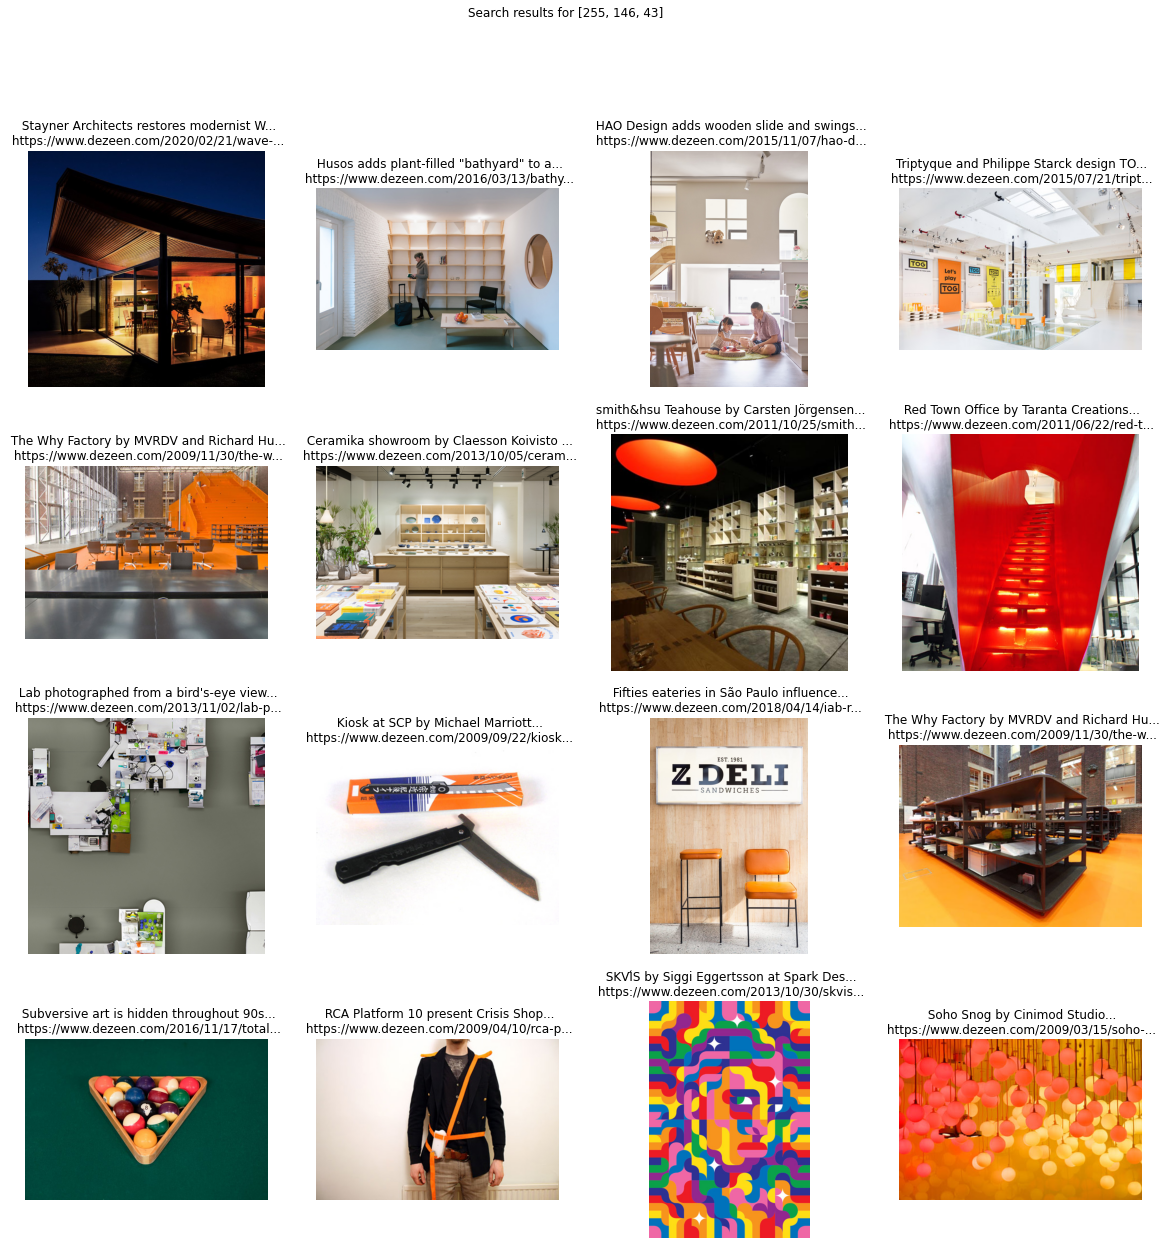

In [47]:
ref_col=[255, 146, 43]
ColorGrid(ref_col)

# Color wheel

https://github.com/CarterWoolsey/woodentify
https://github.com/amankharwal/Website-data/blob/master/colors.csv

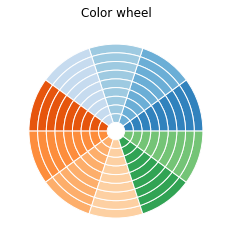

In [ ]:
fig, ax = plt.subplots()

size = 0.1
vals = np.array([[1,1] for a in range(0,10)])

color_list = [
              [[0,0,0],[70,70,70],[125,125,125]],
              [[65,36,20],[116,77,36],[166,124,82]],
              [[110,182,80],[192,212,65],[249,237,37]],
              [[0,104,55],[0,166,82],[35,181,116]],
              [[41,170,227],[86,185,224],[3,169,157]],
              [[147,43,142],[38,33,97],[16,114,187]],
              [[157,31,95],[237,37,123],[240,120,147]],
              [[194,39,45],[240,93,39],[251,176,59]],
              [[170,39,45],[231,111,51],[255,255,255]],

             ]

# cmap = plt.get_cmap("tab20c")
# outer_colors = cmap(np.arange(10))
# inner_colors = cmap(np.arange(10))



for n in range(0,9):
  ax.pie(
      vals.sum(axis=1),
      radius=1-n*size,
      colors=outer_colors,
      wedgeprops=dict(width=size, edgecolor='w')
      )

# ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

# ax.pie(vals.sum(axis=1), radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

# ax.pie(vals.sum(axis=1), radius=1-2*size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect='equal', title='Color wheel')
plt.show()

In [ ]:
inner_colors

array([[0.19215686, 0.50980392, 0.74117647, 1.        ],
       [0.41960784, 0.68235294, 0.83921569, 1.        ],
       [0.61960784, 0.79215686, 0.88235294, 1.        ],
       [0.77647059, 0.85882353, 0.9372549 , 1.        ],
       [0.90196078, 0.33333333, 0.05098039, 1.        ],
       [0.99215686, 0.55294118, 0.23529412, 1.        ],
       [0.99215686, 0.68235294, 0.41960784, 1.        ],
       [0.99215686, 0.81568627, 0.63529412, 1.        ],
       [0.19215686, 0.63921569, 0.32941176, 1.        ],
       [0.45490196, 0.76862745, 0.4627451 , 1.        ]])

# Dropout


https://buzzrobot.com/dominant-colors-in-an-image-using-k-means-clustering-3c7af4622036
https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/
https://i.pinimg.com/236x/31/07/e7/3107e7aded0502e633a6f9b5cda52991--colour-palettes-colour-schemes.jpg
https://github.com/rodartha/ColorPalette/
https://github.com/shourya1997/K-Means-Color-Clustering/blob/master/color_kmeans.ipynb
https://medium.com/swlh/getting-dominant-colour-of-an-image-using-k-means-f7fdca880063
https://github.com/pfnet-research/FSCS
https://answers.opencv.org/question/186712/find-an-image-by-nearest-color/
https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=XrFmZBr9KtAN
https://ailephant.com/dominant-colors-in-image-with-k-means/


# Custom model
Let's now build a custom object detection model based on the downloaded Open Images Dataset using YOLOv4.

https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

## Classes

In [ ]:
classes = [
           'Sink',
           'Stairs',
           'Chair',
           'Cabinetry',
           'Desk',
           'Studio couch',
           'Couch',
           'Door',
           'Shower',
           'Wardrobe',
           'Nightstand',
           'Bathtub',
           'Houseplant',
           'Sofa bed',
           'Curtain',
           'Bed',
           'Fireplace',
           'Bookcase',
           'Table',
           'Mirror',
           'Chest of drawers',
           'Cupboard',
           'Coffee table',
           'Toilet',
           'Bench',
           'Window',
           'Closet',
           'Lamp',
           'Drawer',
           'Stool'
           ]

## Architecture configuration

Copy the original configuration file and perform a find-and-replace on it based on our new dataset.

- `WIDTH` & `HEIGHT` - network size as a value multiple of 32 (typically 416)
- `NUMBER_OF_CLASSES` - number of classes to train
- `MAX_BATCHES` - maximum number of samples to be propagated through the network equal `NUMBER_OF_CLASSES * 2000`
- `STEPS` - 80% & 90% of `MAX_BATCHES` in each of the `[yolo]` layers
- `FILTERS` - `3*(NUMBER_OF_CLASSES + 5)` in each of the `[convolutional]` layer before `[yolo]` layers




In [ ]:
%cd /mydrive/files/

!cp /mydrive/darknet/cfg/yolov4-custom.cfg /mydrive/files/yolov4-test.cfg

WIDTH = 416
WIDTH_ARG = 's/width=608/width={}/'.format(WIDTH)
HEIGHT = 416
HEIGHT_ARG = 's/height=608/height={}/'.format(HEIGHT)
NUMBER_OF_CLASSES = len(classes)
NUMBER_OF_CLASSES_ARG = 's/classes=80/classes={}/'.format(NUMBER_OF_CLASSES)
MAX_BATCHES = int(NUMBER_OF_CLASSES * 2000)
MAX_BATCHES_ARG = 's/max_batches\ =\ 500500/max_batches={}/'.format(MAX_BATCHES) # not less than 6000
STEPS = int(0.8*MAX_BATCHES), int(0.9*MAX_BATCHES)
STEPS_ARG = 's/steps=400000,450000/steps={},{}/'.format(STEPS[0],STEPS[1])
FILTERS = int(3*(NUMBER_OF_CLASSES + 5))
FILTERS_ARG = 's/filters=255/filters={}/'.format(FILTERS)

!sed -i {WIDTH_ARG} yolov4-test.cfg
!sed -i {HEIGHT_ARG} yolov4-test.cfg
!sed -i {NUMBER_OF_CLASSES_ARG} yolov4-test.cfg
!sed -i {MAX_BATCHES_ARG} yolov4-test.cfg
!sed -i {STEPS_ARG} yolov4-test.cfg
!sed -i {FILTERS_ARG} yolov4-test.cfg

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files


## Object names
Create a new file `obj.names` with names of the classes (one per line).

***Note:*** *If a class name has more than one word you need to replace spaces with underscore*


In [ ]:
with open('/mydrive/files/obj.names', 'w') as output:
    output.write('\n'.join([cls.replace(' ', '_') for cls in classes]))

## Datasets file lists
Create a list of files for both train and validation sets.

### Train

In [ ]:
image_files = []
DIR = '/mydrive/data/oid/train/{}/'.format('_'.join(classes))
os.chdir(DIR)

for filename in os.listdir(os.getcwd()):
  if filename.endswith('.jpg'):
    image_files.append(DIR + filename)

with open('/mydrive/files/train.txt', 'w') as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write('\n')
    outfile.close()

### Validation

In [ ]:
image_files = []
DIR = '/mydrive/data/oid/validation/{}/'.format('_'.join(classes))
os.chdir(DIR)

for filename in os.listdir(os.getcwd()):
  if filename.endswith('.jpg'):
    image_files.append(DIR + filename)

with open('/mydrive/files/valid.txt', 'w') as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write('\n')
    outfile.close()

##  Data configuration
Create a new file `obj.data` to put together data info.
- `classes` - number of classes to train
- `train` - list of files in the train dataset
- `valid` - list of files in the validation dataset
- `names` - list of classes' names
- `backup` - a directory to store partial and final weights

In [ ]:
with open('/mydrive/files/obj.data', 'w') as output:
    output.write(
        '''classes = {}
        train = /mydrive/files/train.txt
        valid = /mydrive/files/valid.txt
        names = /mydrive/files/obj.names
        backup = /mydrive/data/'''.format(len(classes))
    )

# Custom detector

## Download pre-trained weights

In [ ]:
!wget -nc https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files


## Train the model

- `detector`:
- `train`:
- `obj.data`: number and names of classes, list of train/val images, backup directory
- `yolov4-obj.cfg`: neural network architecture configuration
- `yolov4-obj_last.weights`: weights file
- `-dont_show`: suppress the display of an image
- `-map`:


In [ ]:
%cd /mydrive/files/
!chmod +x /mydrive/darknet/darknet
# !/mydrive/darknet/darknet detector train /mydrive/files/obj.data /mydrive/files/yolov4-obj.cfg /mydrive/data/yolov4.conv.137 -dont_show -map
!/mydrive/darknet/darknet detector train obj.data yolov4-obj.cfg yolov4-obj_last.weights -dont_show -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 150 Avg (IOU: 0.672726, GIOU: 0.637503), Class: 0.991313, Obj: 0.153902, No Obj: 0.000270, .5R: 1.000000, .75R: 0.000000, count: 3, class_loss = 0.704299, iou_loss = 0.442179, total_loss = 1.146478 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 161 Avg (IOU: 0.756328, GIOU: 0.739269), Class: 0.898477, Obj: 0.443157, No Obj: 0.002621, .5R: 1.000000, .75R: 0.500000, count: 8, class_loss = 1.152707, iou_loss = 0.383281, total_loss = 1.535988 
 total_bbox = 152236, rewritten_bbox = 0.777083 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 139 Avg (IOU: 0.807068, GIOU: 0.804794), Class: 0.967637, Obj: 0.002077, No Obj: 0.000014, .5R: 1.000000, .75R: 1.000000, count: 1, class_loss = 0.250287, iou_loss = 6.770397, total_loss = 7.020685 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 150 Avg (IOU: 0.698891, GIOU: 0.676555), Class: 0.986740, Obj: 0.172384, No O

In [ ]:
showIMG('chart.png')

NameError: ignored

# Test search engine

## Random image test

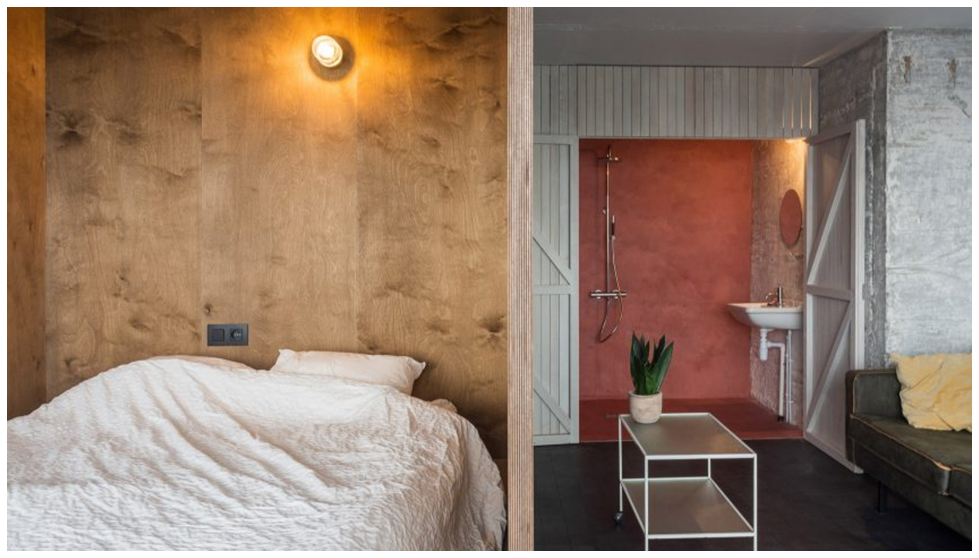

In [ ]:
df_test = results_df.loc[results_df['sofa'] == True].reset_index()

random_filepath = df_test['path'][np.random.randint(0, len(df_test))]

showIMG(random_filepath)

# References

- https://www.analyticssteps.com/blogs/introduction-yolov4
- https://www.youtube.com/watch?v=mmj3nxGT2YQ
- https://blog.roboflow.com/training-yolov4-on-a-custom-dataset/
- https://github.com/pjreddie/darknet/issues/1088
- https://medium.com/ai-world/how-to-train-yolov4-for-custom-objects-detection-in-google-colab-1e934b8ef685
- https://stackoverflow.com/questions/64022836/how-to-train-new-classes-on-pretrained-yolov4-model-in-darknet
- https://github.com/DucLeTrong/YOLOv4_with_OpenImagesV4_GoogleColab 


function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)




function ClickConnect(){

console.log("Working"); 
document.querySelector("#comments > span").click() 
}
setInterval(ClickConnect,5000)




https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting

I tried the codes above but they did not work for me. So here is my JS code for reconnecting.

let interval = setInterval(function(){
let ok = document.getElementById('ok');
if(ok != null){
   console.log("Connect pushed");
ok.click();
}},60000)
You can use it with the same way (run it on the console of your browser) to run it. If you want to stop the script, you can enter clearInterval(interval) and want to run again setInterval(interval).

I hope this helps you.



function ClickConnect(){
console.log("Working"); 
document.querySelector("paper-icon-button").click()
}
Const myjob = setInterval(ClickConnect, 60000)



function ClickRefresh(){
    console.log("Clicked on refresh button"); 
    document.querySelector("paper-icon-button").click()
}
setInterval(ClickRefresh, 60000)

Version 2: If you would like to be able to stop the function, here is the new code:

var startClickConnect = function startClickConnect(){
    var clickConnect = function clickConnect(){
        console.log("Connnect Clicked - Start");
        document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
        console.log("Connnect Clicked - End"); 
    };

    var intervalId = setInterval(clickConnect, 60000);

    var stopClickConnectHandler = function stopClickConnect() {
        console.log("Connnect Clicked Stopped - Start");
        clearInterval(intervalId);
        console.log("Connnect Clicked Stopped - End");
    };

    return stopClickConnectHandler;
};

var stopClickConnect = startClickConnect();
In order to stop, call:

stopClickConnect();